In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input,Reshape, GRU, RepeatVector,Lambda, Dense, LSTM, Conv2D, MaxPooling2D,UpSampling2D, Flatten,Conv2DTranspose
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tsne_python.tsne import tsne 


In [61]:
#load the datasets
train_img = np.load('./quickdraw_subset_np/train_images.npy')
train_lab = np.load('./quickdraw_subset_np/train_labels.npy')
test_img = np.load('./quickdraw_subset_np/test_images.npy')
test_lab = np.load('./quickdraw_subset_np/test_labels.npy')


In [3]:
print(train_img.shape) # (20000, 28, 28)
print(test_img.shape) # (5000, 28, 28)

(20000, 28, 28)
(5000, 28, 28)


In [4]:
num_classes = 5
train_images = train_img.reshape(train_img.shape[0], -1).T / 255.0  # Flatten and normalize
test_images = test_img.reshape(test_img.shape[0], -1).T / 255.0

In [5]:
# One-hot encode labels (assumes labels are 0 to 4)
train_lab_cat = to_categorical(train_lab, num_classes)
test_lab_cat = to_categorical(test_lab, num_classes)


# TASK 1 - Encoder Decoder

## GRU

In [80]:
time_steps = 28
input_dim = 28
latent_dim = 128
num_classes = 5

inputs = Input(shape=(time_steps, input_dim))  # (None, 28, 28)

# Encoder
encoded = GRU(latent_dim, return_sequences=True)(inputs)
encoded = GRU(64)(encoded)

# Decoder
decoded = RepeatVector(time_steps)(encoded)
decoded = GRU(64, return_sequences=True)(decoded)
decoded = GRU(input_dim, return_sequences=True)(decoded)  # Output shape: (None, 28, 28)

# Flatten the decoder output to feed into a classification head
flattened = tf.keras.layers.Flatten()(decoded)

# Classification layer: output is a probability distribution over classes
outputs = Dense(num_classes, activation='softmax')(flattened)



In [82]:
model_gru = Model(inputs, outputs)
model_gru.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_gru.summary()

Model: "model_20018"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 gru_6 (GRU)                 (None, 28, 128)           60672     
                                                                 
 gru_7 (GRU)                 (None, 64)                37248     
                                                                 
 repeat_vector_2 (RepeatVec  (None, 28, 64)            0         
 tor)                                                            
                                                                 
 gru_8 (GRU)                 (None, 28, 64)            24960     
                                                                 
 gru_9 (GRU)                 (None, 28, 28)            7896      
                                                       

In [7]:
# Build the model
model_gru = Model(inputs, outputs)
model_gru.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Train
history_gru = model_gru.fit(train_img, train_lab_cat,
          validation_data=(test_img, test_lab_cat),
          epochs=10,
          batch_size=64)

Epoch 1/10
313/313 [==============================] - 18s 50ms/step - loss: 0.0860 - accuracy: 0.6820 - val_loss: 0.0665 - val_accuracy: 0.7602
Epoch 2/10
313/313 [==============================] - 16s 50ms/step - loss: 0.0587 - accuracy: 0.7962 - val_loss: 0.0594 - val_accuracy: 0.7934
Epoch 3/10
313/313 [==============================] - 15s 48ms/step - loss: 0.0504 - accuracy: 0.8267 - val_loss: 0.0523 - val_accuracy: 0.8204
Epoch 4/10
313/313 [==============================] - 15s 47ms/step - loss: 0.0440 - accuracy: 0.8485 - val_loss: 0.0449 - val_accuracy: 0.8468
Epoch 5/10
313/313 [==============================] - 15s 48ms/step - loss: 0.0392 - accuracy: 0.8679 - val_loss: 0.0425 - val_accuracy: 0.8540
Epoch 6/10
313/313 [==============================] - 16s 50ms/step - loss: 0.0362 - accuracy: 0.8774 - val_loss: 0.0416 - val_accuracy: 0.8592
Epoch 7/10
313/313 [==============================] - 16s 52ms/step - loss: 0.0341 - accuracy: 0.8838 - val_loss: 0.0410 - val_accuracy:

In [8]:
test_loss, test_acc = model_gru.evaluate(test_img, test_lab_cat)
print(f"Test accuracy: {test_acc:.2%}")

157/157 [==============================] - 1s 9ms/step - loss: 0.0405 - accuracy: 0.8628
Test accuracy: 86.28%


In [9]:
encoder_model = Model(inputs, encoded)
embeddings = encoder_model.predict(train_img)

Y = tsne(X=embeddings, no_dims=2, initial_dims=50, perplexity=30.0)

625/625 [==============================] - 5s 7ms/step
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 20000...
Computing P-values for point 500 of 20000...
Computing P-values for point 1000 of 20000...
Computing P-values for point 1500 of 20000...
Computing P-values for point 2000 of 20000...
Computing P-values for point 2500 of 20000...
Computing P-values for point 3000 of 20000...
Computing P-values for point 3500 of 20000...
Computing P-values for point 4000 of 20000...
Computing P-values for point 4500 of 20000...
Computing P-values for point 5000 of 20000...
Computing P-values for point 5500 of 20000...
Computing P-values for point 6000 of 20000...
Computing P-values for point 6500 of 20000...
Computing P-values for point 7000 of 20000...
Computing P-values for point 7500 of 20000...
Computing P-values for point 8000 of 20000...
Computing P-values for point 8500 of 20000...
Computing P-values for point 9000 of 20000...
Computi

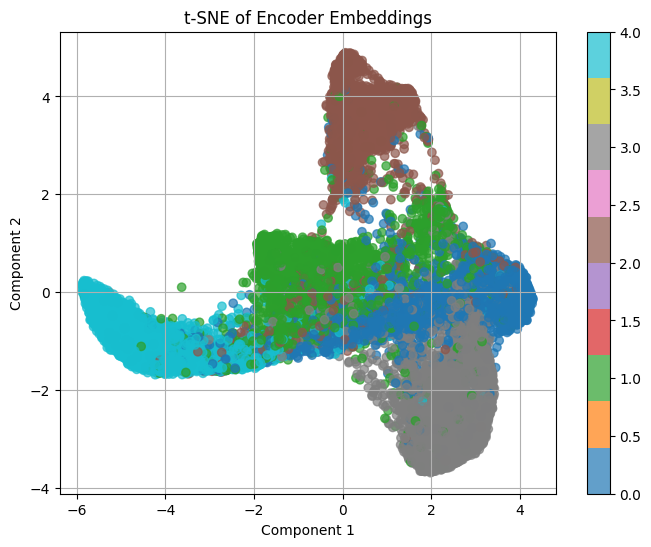

In [10]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(Y[:, 0], Y[:, 1], c=train_lab, cmap='tab10', alpha=0.7)
plt.colorbar(scatter)
plt.title("t-SNE of Encoder Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

## LSTM

In [11]:
# Parameters
time_steps = 28
input_dim = 28
latent_dim = 128
num_classes = 5

# Input
inputs = Input(shape=(time_steps, input_dim))  # (None, 28, 28)

# Encoder
encoded = LSTM(latent_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(inputs)
encoded = LSTM(64)(encoded)

# Decoder
decoded = RepeatVector(time_steps)(encoded)
decoded = LSTM(64, return_sequences=True)(decoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)  # Output shape: (None, 28, 28)

# Classification head
flattened = tf.keras.layers.Flatten()(decoded)
outputs = Dense(num_classes, activation='softmax')(flattened)

# Build and compile model
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Summary (optional)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 lstm (LSTM)                 (None, 28, 128)           80384     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector_1 (RepeatVec  (None, 28, 64)            0         
 tor)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 28, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 28, 28)            10416     
                                                           

In [12]:
# Build the model
model_lstm = Model(inputs, outputs)
model_lstm.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Train
history_lstm = model_lstm.fit(train_img, train_lab_cat,
          validation_data=(test_img, test_lab_cat),
          epochs=10,
          batch_size=64)

Epoch 1/10
313/313 [==============================] - 29s 86ms/step - loss: 0.0827 - accuracy: 0.6940 - val_loss: 0.0622 - val_accuracy: 0.7832
Epoch 2/10
313/313 [==============================] - 27s 85ms/step - loss: 0.0586 - accuracy: 0.7951 - val_loss: 0.0512 - val_accuracy: 0.8180
Epoch 3/10
313/313 [==============================] - 27s 85ms/step - loss: 0.0516 - accuracy: 0.8198 - val_loss: 0.0477 - val_accuracy: 0.8348
Epoch 4/10
313/313 [==============================] - 27s 86ms/step - loss: 0.0465 - accuracy: 0.8403 - val_loss: 0.0483 - val_accuracy: 0.8338
Epoch 5/10
313/313 [==============================] - 27s 87ms/step - loss: 0.0432 - accuracy: 0.8514 - val_loss: 0.0433 - val_accuracy: 0.8464
Epoch 6/10
313/313 [==============================] - 27s 86ms/step - loss: 0.0412 - accuracy: 0.8589 - val_loss: 0.0401 - val_accuracy: 0.8650
Epoch 7/10
313/313 [==============================] - 27s 87ms/step - loss: 0.0387 - accuracy: 0.8672 - val_loss: 0.0400 - val_accuracy:

In [13]:
encoder_model = Model(inputs, encoded)
embeddings = encoder_model.predict(train_img)

Y = tsne(X=embeddings, no_dims=2, initial_dims=50, perplexity=30.0)


625/625 [==============================] - 5s 7ms/step
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 20000...
Computing P-values for point 500 of 20000...
Computing P-values for point 1000 of 20000...
Computing P-values for point 1500 of 20000...
Computing P-values for point 2000 of 20000...
Computing P-values for point 2500 of 20000...
Computing P-values for point 3000 of 20000...
Computing P-values for point 3500 of 20000...
Computing P-values for point 4000 of 20000...
Computing P-values for point 4500 of 20000...
Computing P-values for point 5000 of 20000...
Computing P-values for point 5500 of 20000...
Computing P-values for point 6000 of 20000...
Computing P-values for point 6500 of 20000...
Computing P-values for point 7000 of 20000...
Computing P-values for point 7500 of 20000...
Computing P-values for point 8000 of 20000...
Computing P-values for point 8500 of 20000...
Computing P-values for point 9000 of 20000...
Computi

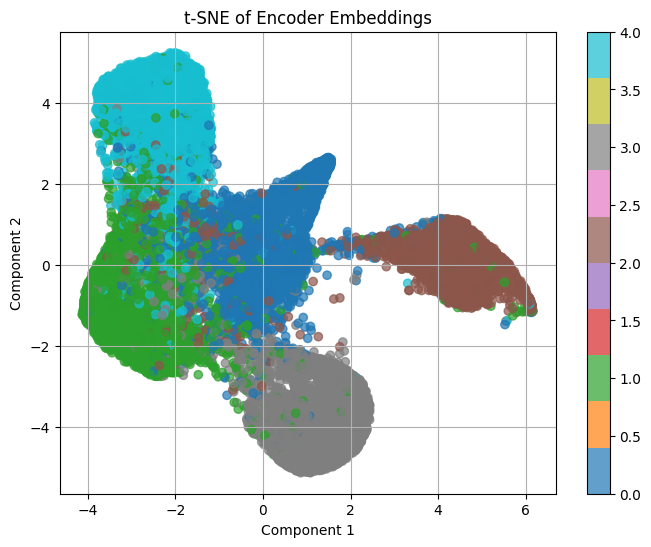

In [14]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(Y[:, 0], Y[:, 1], c=train_lab, cmap='tab10', alpha=0.7)
plt.colorbar(scatter)
plt.title("t-SNE of Encoder Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

## Convolutional approach

In [15]:
input = Input(shape=(28, 28, 1))

encoder = Conv2D(32, (3, 3), activation='relu', padding='same')(input) # 28x28x32
encoder = MaxPooling2D((2, 2), padding='same')(encoder)             # 14x14x32

encoder = Conv2D(64, (3, 3), activation='relu', padding='same')(encoder) # 14x14x64
encoder = MaxPooling2D((2, 2), padding='same')(encoder)             # 7x7x64

encoder = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder) # 7x7x128

decoder = UpSampling2D((2, 2))(encoder) # 14x14x128
decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder) # 14x14x64

decoder = UpSampling2D((2, 2))(decoder) # 28x28x64
decoder = Conv2D(32, (3, 3), activation='relu', padding='same')(decoder) # 28x28x32

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoder) # 28x28x1

# Classification head
flattened = tf.keras.layers.Flatten()(decoded)
outputs = Dense(num_classes, activation='softmax')(flattened)


In [16]:
# Build the model
model_conv = Model(input, outputs)
model_conv.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_conv.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         7385

In [17]:

# Train
history_conv=model_conv.fit(train_img, train_lab_cat,
          validation_data=(test_img, test_lab_cat),
          epochs=10,
          batch_size=64)

Epoch 1/10
313/313 [==============================] - 17s 55ms/step - loss: 0.1046 - accuracy: 0.5882 - val_loss: 0.0694 - val_accuracy: 0.7584
Epoch 2/10
313/313 [==============================] - 18s 58ms/step - loss: 0.0651 - accuracy: 0.7699 - val_loss: 0.0587 - val_accuracy: 0.7978
Epoch 3/10
313/313 [==============================] - 19s 61ms/step - loss: 0.0577 - accuracy: 0.7983 - val_loss: 0.0509 - val_accuracy: 0.8282
Epoch 4/10
313/313 [==============================] - 20s 65ms/step - loss: 0.0479 - accuracy: 0.8361 - val_loss: 0.0480 - val_accuracy: 0.8284
Epoch 5/10
313/313 [==============================] - 21s 67ms/step - loss: 0.0425 - accuracy: 0.8556 - val_loss: 0.0416 - val_accuracy: 0.8606
Epoch 6/10
313/313 [==============================] - 21s 69ms/step - loss: 0.0470 - accuracy: 0.8400 - val_loss: 0.0500 - val_accuracy: 0.8312
Epoch 7/10
313/313 [==============================] - 22s 71ms/step - loss: 0.0520 - accuracy: 0.8201 - val_loss: 0.0449 - val_accuracy:

In [18]:
encoder_model = Model(inputs, encoded)
embeddings = encoder_model.predict(train_img)

Y = tsne(X=embeddings, no_dims=2, initial_dims=50, perplexity=30.0)

625/625 [==============================] - 5s 8ms/step
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 20000...
Computing P-values for point 500 of 20000...
Computing P-values for point 1000 of 20000...
Computing P-values for point 1500 of 20000...
Computing P-values for point 2000 of 20000...
Computing P-values for point 2500 of 20000...
Computing P-values for point 3000 of 20000...
Computing P-values for point 3500 of 20000...
Computing P-values for point 4000 of 20000...
Computing P-values for point 4500 of 20000...
Computing P-values for point 5000 of 20000...
Computing P-values for point 5500 of 20000...
Computing P-values for point 6000 of 20000...
Computing P-values for point 6500 of 20000...
Computing P-values for point 7000 of 20000...
Computing P-values for point 7500 of 20000...
Computing P-values for point 8000 of 20000...
Computing P-values for point 8500 of 20000...
Computing P-values for point 9000 of 20000...
Computi

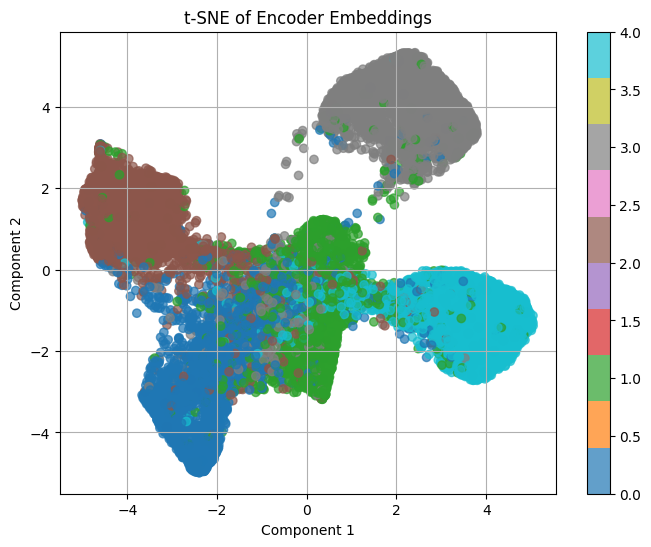

In [19]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(Y[:, 0], Y[:, 1], c=train_lab, cmap='tab10', alpha=0.7)
plt.colorbar(scatter)
plt.title("t-SNE of Encoder Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

## MSE loss variation

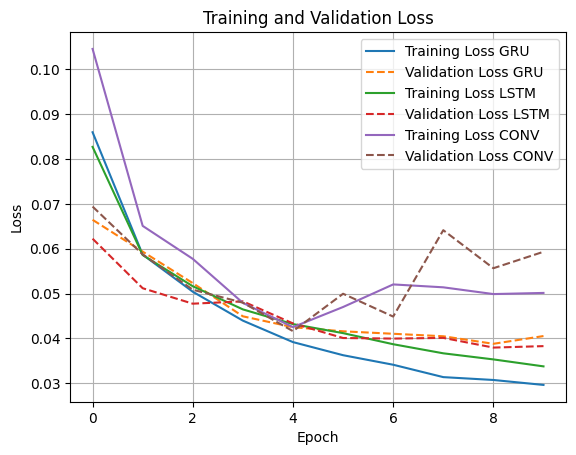

In [20]:
#plot the loss for each model
plt.plot(history_gru.history['loss'], label='Training Loss GRU')
plt.plot(history_gru.history['val_loss'], label='Validation Loss GRU', linestyle='--') 
plt.plot(history_lstm.history['loss'], label='Training Loss LSTM')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss LSTM', linestyle='--')
plt.plot(history_conv.history['loss'], label='Training Loss CONV')
plt.plot(history_conv.history['val_loss'], label='Validation Loss CONV', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# VAE

# GRU encoder + convolutional decoder

In [90]:
# === Settings ===
latent_dim = 32
timesteps = 28
features = 28

# === Input ===
inputs = Input(shape=(timesteps, features))  # e.g., (28, 28)

# === GRU Encoder ===
x = GRU(latent_dim, return_sequences=True)(inputs)
x = GRU(64)(x)

# === Latent Space ===
mu = Dense(latent_dim)(x)
log_var = Dense(latent_dim)(x)

# Reparameterization trick
def sample_z(args):
    mu, log_var = args
    epsilon = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.exp(0.5 * log_var) * epsilon

z = Lambda(sample_z)([mu, log_var])

# === Decoder ===
# Map latent z to shape compatible with CNN decoder
x = Dense(7 * 7 * 128, activation='relu')(z)
x = Reshape((7, 7, 128))(x)

x = UpSampling2D((2, 2))(x)                           # 14x14x128
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)  # 14x14x64

x = UpSampling2D((2, 2))(x)                           # 28x28x64
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # 28x28x32

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # 28x28x1

# === VAE Model ===
vae = Model(inputs, [decoded, mu, log_var])

# === Loss Function ===
def compute_vae_loss(x_true, x_pred, mu, log_var):
    recon_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.reshape(x_true, [-1, 28*28]), tf.reshape(x_pred, [-1, 28*28])))
    recon_loss *= 28 * 28

    kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    total_loss = recon_loss + kl_loss
    return total_loss, recon_loss, kl_loss



In [94]:
vae.summary()

Model: "model_20021"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 28, 28)]             0         []                            
                                                                                                  
 gru_14 (GRU)                (None, 28, 32)               5952      ['input_18[0][0]']            
                                                                                                  
 gru_15 (GRU)                (None, 64)                   18816     ['gru_14[0][0]']              
                                                                                                  
 dense_26 (Dense)            (None, 32)                   2080      ['gru_15[0][0]']              
                                                                                        

In [92]:
optimizer = tf.keras.optimizers.legacy.Adam(1e-3)

epochs = 10
batch_size = 64

train_seq = train_images.reshape(-1, 28, 28)  # <-- shape: (num_samples, time, features)
train_seq = train_seq.astype(np.float32)

train_ds = tf.data.Dataset.from_tensor_slices(train_seq)
train_ds = train_ds.shuffle(1024).batch(batch_size)

recon_log = []
kl_log = []

for epoch in range(epochs):
    total_recon, total_kl = 0.0, 0.0
    for step, x_batch in enumerate(train_ds):
        with tf.GradientTape() as tape:
            x_decoded, mu_out, log_var_out = vae(x_batch, training=True)
            loss, recon_loss, kl_loss = compute_vae_loss(x_batch, x_decoded, mu_out, log_var_out)

        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        total_recon += recon_loss.numpy()
        total_kl += kl_loss.numpy()

    recon_log.append(total_recon)
    kl_log.append(total_kl)
    print(f"Epoch {epoch+1}, Recon: {total_recon:.2f}, KL: {total_kl:.2f}")

Epoch 1, Recon: 94335.36, KL: 261.27
Epoch 2, Recon: 94201.39, KL: 195.83
Epoch 3, Recon: 94070.64, KL: 175.27
Epoch 4, Recon: 93957.26, KL: 180.31
Epoch 5, Recon: 93831.93, KL: 183.32
Epoch 6, Recon: 93719.30, KL: 184.28
Epoch 7, Recon: 93653.88, KL: 184.85
Epoch 8, Recon: 93558.47, KL: 198.77
Epoch 9, Recon: 93348.74, KL: 236.65
Epoch 10, Recon: 93186.71, KL: 263.91


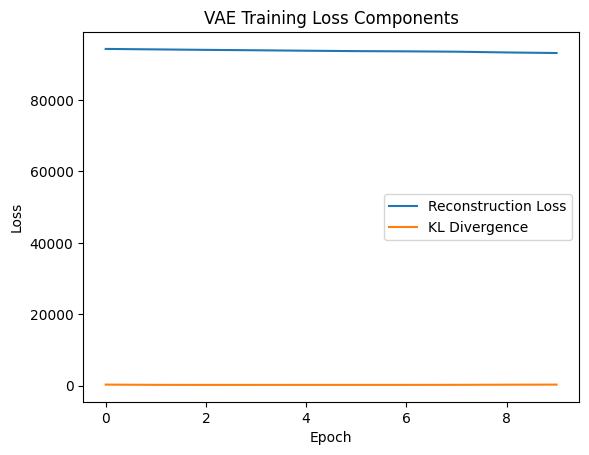

In [93]:
plt.plot(recon_log, label="Reconstruction Loss")
plt.plot(kl_log, label="KL Divergence")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("VAE Training Loss Components")
plt.show()

## Convolutional encoder + convolutional decoder


In [95]:
input_shape = (28, 28, 1)
latent_dim = 16

# Encoder
inputs = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='tanh', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='tanh', padding='same')(x)
shape_before_flatten = K.int_shape(x)[1:]
x = Flatten()(x)

mu = Dense(latent_dim, name="mu")(x)
log_var = Dense(latent_dim, name="log_var")(x)

def sampling(args):
    mu, log_var = args
    log_var = tf.clip_by_value(log_var, -10.0, 10.0)  # 🔥 critical!
    epsilon = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.exp(0.5 * log_var) * epsilon

z = Lambda(sampling, name="z")([mu, log_var])

decoder_input = Dense(np.prod(shape_before_flatten), activation='tanh')(z)
x = Reshape(shape_before_flatten)(decoder_input)

x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='tanh', padding='same')(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='tanh', padding='same')(x)

outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="reconstruction")(x)

# Full VAE model with multiple outputs
vae = Model(inputs, [outputs, mu, log_var])

In [106]:
vae.summary()

Model: "model_20022"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_65 (Conv2D)          (None, 28, 28, 32)           320       ['input_19[0][0]']            
                                                                                                  
 max_pooling2d_17 (MaxPooli  (None, 14, 14, 32)           0         ['conv2d_65[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_66 (Conv2D)          (None, 14, 14, 64)           18496     ['max_pooling2d_17[0

In [74]:
def compute_vae_loss(x, x_decoded, mu, log_var):
    x = K.flatten(x)
    x_decoded = K.flatten(x_decoded)
    
    recon_loss = binary_crossentropy(x, x_decoded)
    recon_loss *= 28 * 28

    kl_loss = -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
    total_loss = K.mean(recon_loss + kl_loss)

    return total_loss, K.mean(recon_loss), K.mean(kl_loss)
# Optimizer
optimizer = tf.keras.optimizers.Adam()

In [75]:
batch_size = 128
#regularize train_img
train_img1 = train_img.astype("float32") / 255.0
train_img1 = np.expand_dims(train_img1, -1)

train_ds = tf.data.Dataset.from_tensor_slices(train_img1)
train_ds = train_ds.shuffle(buffer_size=1024).batch(batch_size)

In [76]:
for x_batch in train_ds.take(1):
    print("x_batch shape:", x_batch.shape)  # Should be (128, 28, 28, 1)

x_batch shape: (128, 28, 28, 1)


In [78]:
recon_losses = []
kl_losses = []

for epoch in range(20):
    total_recon = total_kl = 0
    for step, x_batch in enumerate(train_ds):
        with tf.GradientTape() as tape:
            x_decoded, mu_out, log_var_out = vae(x_batch, training=True)
            loss, recon_loss, kl_loss = compute_vae_loss(x_batch, x_decoded, mu_out, log_var_out)
        
        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        total_recon += recon_loss.numpy()
        total_kl += kl_loss.numpy()

    recon_losses.append(total_recon / len(train_ds))
    kl_losses.append(total_kl / len(train_ds))
    print(f"Epoch {epoch+1}, Recon: {recon_losses[-1]:.2f}, KL: {kl_losses[-1]:.2f}")

Epoch 1, Recon: 245.97, KL: 15.86
Epoch 2, Recon: 213.48, KL: 21.57
Epoch 3, Recon: 203.51, KL: 23.09
Epoch 4, Recon: 197.10, KL: 24.17
Epoch 5, Recon: 193.09, KL: 24.67
Epoch 6, Recon: 190.69, KL: 25.00
Epoch 7, Recon: 188.55, KL: 25.41
Epoch 8, Recon: 187.27, KL: 25.54
Epoch 9, Recon: 185.79, KL: 25.88
Epoch 10, Recon: 185.01, KL: 25.98
Epoch 11, Recon: 183.92, KL: 26.16
Epoch 12, Recon: 182.97, KL: 26.36
Epoch 13, Recon: 182.50, KL: 26.42
Epoch 14, Recon: 181.66, KL: 26.56
Epoch 15, Recon: 180.87, KL: 26.69
Epoch 16, Recon: 180.52, KL: 26.79
Epoch 17, Recon: 180.12, KL: 26.82
Epoch 18, Recon: 179.35, KL: 26.93
Epoch 19, Recon: 178.88, KL: 27.02
Epoch 20, Recon: 178.42, KL: 27.18


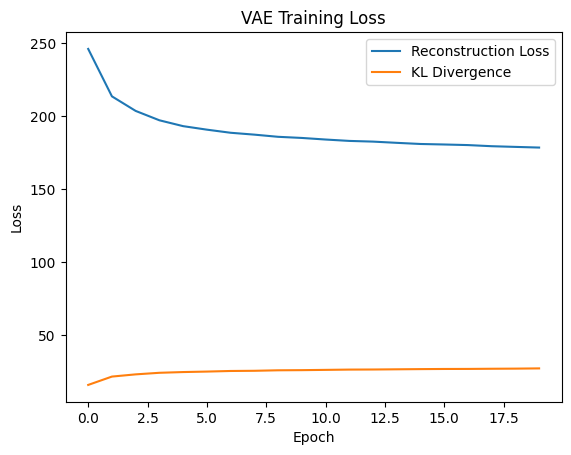

In [79]:
plt.plot(recon_losses, label='Reconstruction Loss')
plt.plot(kl_losses, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.legend()
plt.show()